# Image Classification with Transfer Learning

### In this project, we utilize transfer learning for image classification using a pre-trained VGG16 model on the CIFAR-10 dataset. By fine-tuning this model on our specific dataset, we aim to improve classification accuracy efficiently. This Jupyter notebook will guide you through the process of data preparation, model adaptation, training, and evaluation.



#### The CIFAR-10 dataset is a standard benchmark dataset for image classification, containing 60,000 32x32 color images in 10 classes.

### Main Objective

#### Evaluate the effectiveness of Transfer Learning to enhance the accuracy of image classification.

### Expected Outcomes

#### Accurate Image Classification: Achieve high levels of accuracy in classifying images, demonstrating the effectiveness of Transfer Learning


In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Loading and Preprocessing the CIFAR-10 Dataset

In [3]:
# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


### Normalization: Image pixel values range from 0 to 255. Dividing by 255 scales them to a range of 0 to 1, which helps in faster convergence during training.


In [4]:
# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [5]:
# Check the shape of the images
print("Train images shape:", train_images.shape)  # Expected: (num_samples, 32, 32, 3)
print("Test images shape:", test_images.shape)    # Expected: (num_samples, 32, 32, 3)

# Check the data type of the images
print("Train images data type:", train_images.dtype)  # Expected: float32
print("Test images data type:", test_images.dtype)    # Expected: float32

# Check the range of pixel values
print("Train images min:", train_images.min())  # Expected: 0.0
print("Train images max:", train_images.max())  # Expected: 1.0
print("Test images min:", test_images.min())    # Expected: 0.0
print("Test images max:", test_images.max())    # Expected: 1.0

Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train images data type: float32
Test images data type: float32
Train images min: 0.0
Train images max: 1.0
Test images min: 0.0
Test images max: 1.0


### One-hot encoding: Converts class labels into a format suitable for training a neural network, where each class is represented as a binary vector.

In [6]:
# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

### Visualizing the Data

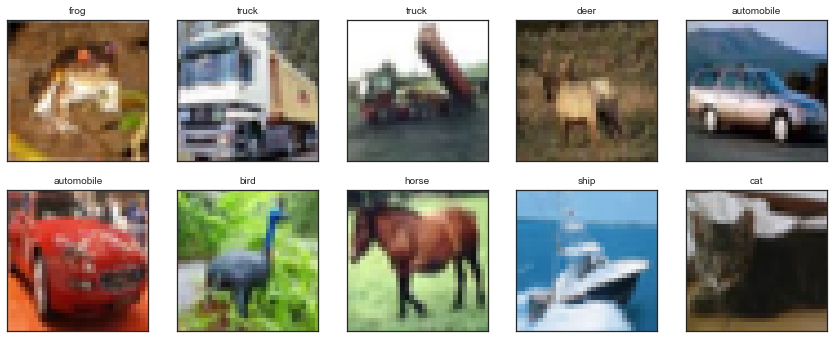

In [7]:

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Set the Seaborn style
sns.set(style='white', context='notebook', font_scale=1.2)

# Visualize the first 25 images from the training set with better quality
plt.figure(figsize=(12, 12))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.set_aspect('equal')
    ax.set_title(class_names[np.argmax(train_labels[i])], fontsize=10)
plt.tight_layout()
plt.show()



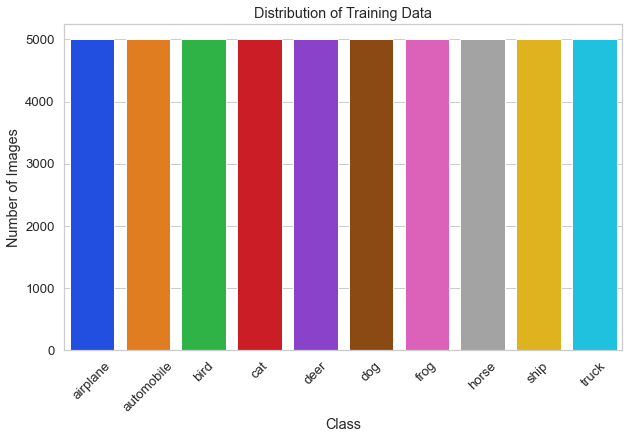

In [8]:
# Plot the distribution of the training dataset
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Convert labels from one-hot encoding to class indices
train_labels_indices = np.argmax(train_labels, axis=1)

# Create the count plot with class names as x-axis labels
sns.countplot(train_labels_indices, palette='bright')
plt.title('Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Update x-axis labels with class names
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.show()


### Data Augmentation: ImageDataGenerator is used to augment the training data, which helps in reducing overfitting.



In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
datagen.fit(train_images)

### Loading and Modifying the Pre-trained VGG16 Model

#### Why VGG16?: VGG16 is a well-known deep learning model pre-trained on the ImageNet dataset. Using a pre-trained model helps leverage learned features, making the training faster and potentially more accurate.
#### Freezing layers: Prevents the weights of the VGG16 base model from being updated during training, which is useful when the base model already performs well on similar tasks.

In [10]:
# Load the VGG16 model pre-trained on ImageNet, without the top layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the first 12 layers of VGG16
for layer in vgg16_base.layers[:12]:
    layer.trainable = False

# Unfreeze the remaining layers
for layer in vgg16_base.layers[12:]:
    layer.trainable = True

### Adding Custom Top Layers

##### Custom layers: Add fully connected layers on top of the VGG16 base to tailor the model to the CIFAR-10 classification task.
#### Regularization: Besides l2 regularization, adding l1 or elastic net regularization. These techniques can help prevent overfitting by penalizing large weights.
##### Batch Normalization: Helps in faster convergence and stability during training.
##### Dropout: Prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time.

In [11]:
# Add custom top layers
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())        
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.65))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

### Compiling the Model

In [12]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


### Training the Model with Callbacks

##### EarlyStopping: Stops training when the validation loss stops improving, preventing overfitting.
##### ModelCheckpoint: Saves the model with the best validation performance.
##### ReduceLROnPlateau: Reduces the learning rate when the validation performance plateaus, which helps in fine-tuning the learning process.

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


# Train the model with data augmentation
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    epochs=50, 
                    validation_data=(test_images, test_labels),
                    callbacks=callbacks)

Epoch 1/50
1563/1563 [==============================] - 707s 451ms/step - loss: 47.2196 - accuracy: 0.1307 - val_loss: 40.4744 - val_accuracy: 0.1706 - lr: 1.0000e-04
Epoch 2/50
1563/1563 [==============================] - 715s 458ms/step - loss: 36.7312 - accuracy: 0.1813 - val_loss: 31.8772 - val_accuracy: 0.1592 - lr: 1.0000e-04
Epoch 3/50
1563/1563 [==============================] - 705s 451ms/step - loss: 27.6229 - accuracy: 0.2068 - val_loss: 22.8892 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 4/50
1563/1563 [==============================] - 699s 447ms/step - loss: 18.6907 - accuracy: 0.2406 - val_loss: 14.3854 - val_accuracy: 0.2655 - lr: 1.0000e-04
Epoch 5/50
1563/1563 [==============================] - 681s 436ms/step - loss: 10.9325 - accuracy: 0.2688 - val_loss: 7.6742 - val_accuracy: 0.3180 - lr: 1.0000e-04
Epoch 6/50
1563/1563 [==============================] - 674s 431ms/step - loss: 5.8511 - accuracy: 0.3351 - val_loss: 4.2497 - val_accuracy: 0.4409 - lr: 1.0000e-04
E

### Evaluating the Model


#### Measures the model's performance on the test set to see how well it generalizes to new, unseen data

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc:.4f}')

313/313 [==============================] - 27s 87ms/step - loss: 1.6496 - accuracy: 0.7980
Test accuracy: 0.7980


### Plotting Training and Validation Metrics

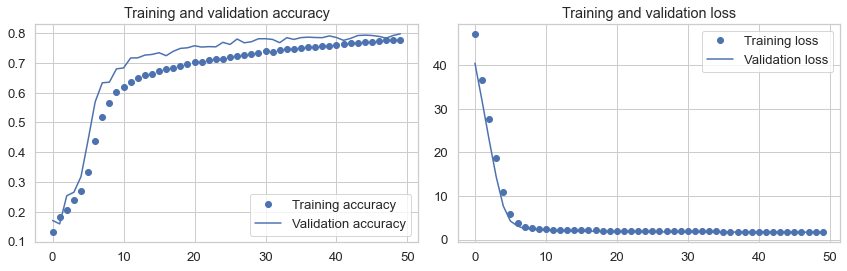

In [15]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Save the trained model
model.save('cifar10_vgg16_model.h5')

### Conclusions

###  It has been created a well-generalized image classification model using the CIFAR-10 dataset and VGG16 model.

### After 50 epochs of training, the model has demonstrated a promising performance with a final training loss of 1.7377 and an accuracy of 77.58%. On the validation set, the model achieved a slightly lower loss of 1.6496 and a higher accuracy of 79.80%. These results indicate that the model is effectively learning from the training data and generalizing well to unseen data. The learning rate of 0.0001 appears to have been appropriate for this training process, allowing the model to converge to a satisfactory level of performance. 


### For Quick Prototyping, using a single train-test split is acceptable, offering simplicity and speed with a limited computational power.

### Future improvements could focus on further tuning hyperparameters or experimenting with different model architectures to enhance performance even more.:


### * Model Architecture: Freezing the first 12 layers of VGG16 and fine-tuning the remaining layers is a good strategy. However, is possible to experiment with different numbers of layers to freeze/unfreeze to see if it affects performance.

### * Cross-Validation: Instead of a single train-test split, the use of k-fold cross-validation to better evaluate the model's performance is a key point to consider.


### * Transfer Learning Alternatives: Experiment with other pre-trained models, to see if they perform better.